In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load the dataset

In [3]:
ds = pd.read_csv('CO2 Emissions_Canada.csv')
ds = ds[ds['Fuel Type'] != 'N']
ds.head()

,Make,Model,Vehicle Class,Engine Size(L),Cylinders,Transmission,Fuel Type,Fuel Consumption City (L/100 km),Fuel Consumption Hwy (L/100 km),Fuel Consumption Comb (L/100 km),Fuel Consumption Comb (mpg),CO2 Emissions(g/km)
0,ACURA,ILX,COMPACT,2.0,4,AS5,Z,9.9,6.7,8.5,33,196
1,ACURA,ILX,COMPACT,2.4,4,M6,Z,11.2,7.7,9.6,29,221
2,ACURA,ILX HYBRID,COMPACT,1.5,4,AV7,Z,6.0,5.8,5.9,48,136
3,ACURA,MDX 4WD,SUV - SMALL,3.5,6,AS6,Z,12.7,9.1,11.1,25,255
4,ACURA,RDX AWD,SUV - SMALL,3.5,6,AS6,Z,12.1,8.7,10.6,27,244


In [4]:
y = ds["CO2 Emissions(g/km)"]
X_orig = ds.drop(columns=["CO2 Emissions(g/km)"])

# 2. Create Transformers

In [5]:
from pyreal.transformers import Transformer, OneHotEncoder, StandardScaler, ColumnDropTransformer
from sklearn.preprocessing import OrdinalEncoder

def aggregate_transmission(df):
    df['Transmission'] = np.where(df['Transmission'].isin(['A4','A5','A6','A7','A8','A9','A10']),'Automatic',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AS4','AS5','AS6','AS7','AS8','AS9','AS10']),'Automatic of Selective type',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AM5','AM6','AM7','AM8','AM9']),'Automated Manual',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['AV','AV6','AV7','AV8','AV10']),'CVT',df['Transmission'])
    df['Transmission'] = np.where(df['Transmission'].isin(['M5','M6','M7']),'Manual',df['Transmission'])
    return df

def rename_fuel_type(df):
    df['Fuel Type']= np.where(df['Fuel Type']=='X','Regular gasoline',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='Z','Premium gasoline',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='E','Ethanol',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='D','Diesel',df['Fuel Type'])
    df['Fuel Type']= np.where(df['Fuel Type']=='N','Natural gas',df['Fuel Type'])
    return df

transmission_transformer = Transformer.from_transform_function(aggregate_transmission)
transmission_transformer.set_flags(model=True, interpret=True)

fuel_transformer = Transformer.from_transform_function(rename_fuel_type)
fuel_transformer.set_flags(model=True, interpret=True)

one_hot_encoder = OneHotEncoder(columns=["Fuel Type", "Transmission"])

dropper = ColumnDropTransformer(columns=["Model"])

ordinal_encoder = Transformer(OrdinalEncoder(), columns=["Make", "Vehicle Class"])

scaler = StandardScaler()

transformers = [transmission_transformer, fuel_transformer, one_hot_encoder, dropper, ordinal_encoder, scaler]

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


# 3. Train model

In [6]:
from sklearn.model_selection import train_test_split
from pyreal.transformers import run_transformers, fit_transformers

X_train, X_test, y_train, y_test = train_test_split(X_orig, y, test_size=0.2, random_state=42)

X_train_model = fit_transformers(transformers, X_train)
X_test_model = run_transformers(transformers, X_test)

RMSE: 2.4308
MAE: 1.6538
R2_score: 0.9983


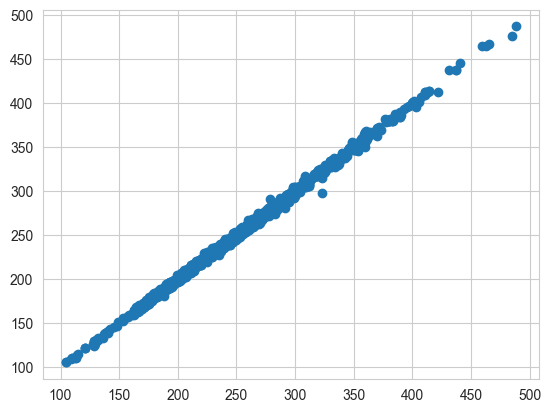

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error ,r2_score, mean_absolute_error

model = RandomForestRegressor()
model.fit(X_train_model, y_train)

preds = model.predict(X_test_model)

print('RMSE: {:0.4f}'.format(np.sqrt(mean_squared_error(y_test, preds))))
print('MAE: {:0.4f}'.format(mean_absolute_error(y_test, preds)))
print('R2_score: {:0.4f}'.format(r2_score(y_test, preds)))
plt.scatter(preds, y_test)

# 4. Make RealApp

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


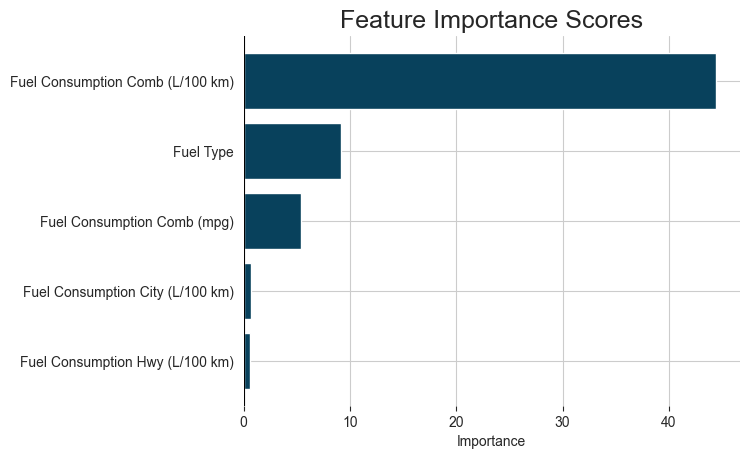

In [8]:
from pyreal import RealApp
from pyreal.visualize import feature_bar_plot
import yaml

with open('key.yaml', 'r') as file:
    key = yaml.load(file, Loader=yaml.FullLoader)['openai_key']

context_description = "The model predicts the CO2 emissions of a cars, in grams per kilometer. "
app = RealApp(model, 
              transformers=transformers, 
              X_train_orig=X_train, 
              y_train=y_train, 
              openai_api_key=key,
              context_description=context_description)

importance = app.produce_feature_importance(training_size=100)
feature_bar_plot(importance)

In [9]:
display(app.produce_feature_contributions(X_test.iloc[0]))

app.produce_narrative_feature_contributions(X_test.iloc[0])

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


,Feature Name,Feature Value,Contribution,Average/Mode
0,Make,CHEVROLET,0.154831,CHEVROLET
1,Model,Corvette ZR1,0.000000,Corvette ZR1
2,Vehicle Class,TWO-SEATER,0.042788,TWO-SEATER
3,Engine Size(L),6.2,0.111290,6.2
4,Cylinders,8,-0.007089,8
5,Fuel Consumption City (L/100 km),18.2,0.148227,18.2
6,Fuel Consumption Hwy (L/100 km),12.5,0.330399,12.5
7,Fuel Consumption Comb (L/100 km),15.6,97.316449,15.6
8,Fuel Consumption Comb (mpg),18,10.471017,18
9,Fuel Type,Premium gasoline,6.595811,Premium gasoline


DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


['The model thinks that having a fuel consumption of 15.6 liters per 100 kilometers contributes the most to the predicted CO2 emissions, adding about 97 grams per kilometer. Using premium gasoline as fuel also increases the emissions by about 6.6 grams. A fuel consumption of 18 miles per gallon contributes about 10.5 grams. A highway fuel consumption of 12.5 liters per 100 kilometers adds around 0.33 grams. Lastly, being a Chevrolet car slightly increases the emissions by about 0.15 grams.']

In [10]:
app.train_feature_contribution_llm()

DataFrame.groupby with axis=1 is deprecated. Do `frame.T.groupby(...)` without axis instead.


For each of the following inputs, please provide an appropriate narrative version.
Input 1 (feature, value, contribution):
(Fuel Consumption Comb (L/100 km),
9.1, -32.234205983728174),
(Fuel Consumption Comb (mpg),
31, -3.536731959693134),
(Fuel Type, Regular gasoline, 2.1964435893064365)
Training data not saved.
